In [1]:
import tarfile
import io
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, spearmanr
from fmriprep_denoise.metrics import partial_correlation, fdr, calculate_median_absolute


# Load metric data
path_root = Path.cwd().parents[0] / "inputs"
file_qcfc = "dataset-ds000288_atlas-schaefer7networks_nroi-400_desc-qcfc.tsv"
file_dist = "atlas-schaefer7networks_nroi-400_desc-distance.tsv"
file_network = "dataset-ds000288_atlas-schaefer7networks_nroi-400_desc-modularity.tsv"
file_dataset = "dataset-ds000288.tar.gz"


# load data
with tarfile.open(path_root / file_dataset, 'r:gz') as tar:
    movement = tar.extractfile(
        "dataset-ds000288/dataset-ds000288_desc-movement_phenotype.tsv").read()
    movement = pd.read_csv(io.BytesIO(movement),
                        sep='\t', index_col=0, header=0, encoding='utf8')
    movement = movement.sort_index()

In [2]:
pairwise_distance = pd.read_csv(path_root / file_dist, sep='\t')

qcfc = pd.read_csv(path_root / file_qcfc, sep='\t', index_col=0)
modularity = pd.read_csv(path_root / file_network, sep='\t', index_col=0)


# separate correlation from siginficant value
sig_per_edge = qcfc.filter(regex="pvalue")
sig_per_edge.columns = [col.split('_')[0] for col in sig_per_edge.columns]
metric_per_edge = qcfc.filter(regex="correlation")
metric_per_edge.columns = [col.split('_')[0] for col in metric_per_edge.columns]

# OHBM 2022 abstract

## Impact of confound removal strategies on functional connectivity generated from fMRIPrep outputs

H-T Wang[^1], S L Meisler[^2][^3], N Gensollen[^4], B Thirion[^4], P Bellec[^1][^5]

[^1] Centre de recherche de l'institut Universitaire de gériatrie de Montréal (CRIUGM), Montréal, Québec, Canada
[^2] Harvard University, MA, USA
[^3] Massachusetts Institute of Technology, MA, USA
[^4] Inria, CEA, Université Paris-Saclay, Paris, France
[^5] Psychology Department, Université de Montréal, Montréal, Québec, Canada




### Introduction

The impact of the choice of confound regressor on functional connectivity has been a key debate in the field of fMRI. 
Popular preprocessing software, fMRIPrep {cite:p}`esteban_fmriprep_2020`, aims to reduce the degree of freedom during the preprocessing step. 
However, a wide range of confound regressors can still introduce errors by the users. 
Without good understanding of the literature or the fMRIPrep documentation, users can still introduce error or unwanted noise while performing confound regressing. 
Lastly, recent literature has shown the tool-based variability and the potential impact on the results {cite:p}`li_moving_2021`. 
The current research on denoising benchmarks have yet to cover the output from fMRIPrep. 
We hope to provide a useful reference for fMRIPrep users, and evaluate whether the confound regressors from fMRIPrep provide results consistent with the past literature using other preprocessing procedures.    

### Methods

The dataset of choice is ds000228 {cite:p}`richardson_development_2018` on OpenNeuro, preprocessed with fMRIprep LTS20.2.1, using fMRIPrep-slurm wrapper with option `--use-aroma`. 
After fMRIPrep, regular BOLD outputs were smoothed with a 6 mm FWHM kernel.
Time series are extracted using Schaefer 7 network atlas of 400 dimensions {cite:p}`schaefer_local-global_2017` and applied the following denoising strategies:

| strategy   | image                          | `high_pass` | `motion` | `wm_csf` | `global_signal` | `scrub` | `fd_thresh` | `compcor`     | `n_compcor` | `ica_aroma` | `demean` |
|------------|--------------------------------|-------------|----------|----------|-----------------|---------|-------------|---------------|-------------|-------------|----------|
| baseline   | `desc-preproc_bold`            | `True`      | N/A      | N/A      | N/A             | N/A     | N/A         | N/A           | N/A         | N/A         | `True`   |
| simple     | `desc-preproc_bold`            | `True`      | full     | basic    | N/A             | N/A     | N/A         | N/A           | N/A         | N/A         | `True`   |
| simple+gsr | `desc-preproc_bold`            | `True`      | full     | basic    | basic           | N/A     | N/A         | N/A           | N/A         | N/A         | `True`   |
| scrubbing  | `desc-preproc_bold`            | `True`      | full     | full     | N/A             | 5       | 0.5         | N/A           | N/A         | N/A         | `True`   |
| simple+gsr | `desc-preproc_bold`            | `True`      | full     | full     | basic           | 5       | 0.5         | N/A           | N/A         | N/A         | `True`   |
| compcor    | `desc-preproc_bold`            | `True`      | full     | N/A      | N/A             | N/A     | N/A         | anat_combined | all         | N/A         | `True`   |
| compcor6   | `desc-preproc_bold`            | `True`      | full     | N/A      | N/A             | N/A     | N/A         | anat_combined | 6           | N/A         | `True`   |
| aroma      | `desc-smoothAROMAnonaggr_bold` | `True`      | N/A      | basic    | N/A             | N/A     | N/A         | N/A           | N/A         | full        | `True`   |
| aroma+gsr  | `desc-smoothAROMAnonaggr_bold` | `True`      | N/A      | basic    | basic           | N/A     | N/A         | N/A           | N/A         | full        | `True`   |

In addition, we also calculated the connectome based on the raw timeseries as a reference.

Here we provide an uniformed API to retrieve fMRIPrep generated confounds implemented in NiLearn {cite:p}`abraham_machine_2014`. 
Timeseries, connectome, and confounds removal are all implemented through NiLearn.

The current study used three metrics from {cite:t}`ciric_benchmarking_2017` to evaluate the denosing results: 
1. Quality control / functional connectivity (QCFC {cite:p}`power_recent_2015`): Partial correlation between motion and connectivity with age and sex as covariates; multiple comparison in the significant testing is controled with false positive rate correction.
2. Distance-dependent effects of motion on connectivity {cite:p}`power_spurious_2012`
3. Network identifiability based on Louvain method of community detection {cite:p}`satterthwaite_impact_2012` implemented by Brain Connnectome Toolbox

Code and processed data to reproduce the current analysis can be found on [github](https://github.com/SIMEXP/fmriprep-denoise-benchmark). 

### Results

#### Mean framewise displacement
No denoising can remove the correlation with motion captured by mean framewise displacement. 
`aroma`, `acompcor6`, and `simple` reduced correlation between connectivity edges and mean framewise displacement. 
`scrubbing` and `scrubbing+gsr` did not perform as well as in the past literature, possibly due to the liberal threshold used on the current dataset. 
`acompcor`, the suggested method of applying compcor based regressors, performs worse than the baseline of connectome created with raw time series. 
Surprisingly, all strategies with GSR underperform, contradicting the existing literature.

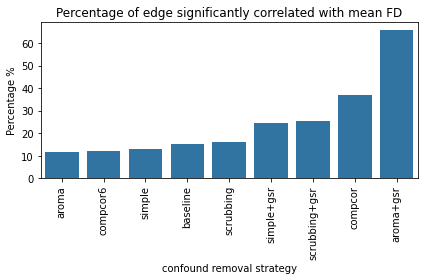

In [14]:
bar_color = sns.color_palette()[0]

# multiple comparision on qcfc
long_qcfc_sig= sig_per_edge.melt()
long_qcfc_sig['fdr'] = long_qcfc_sig.groupby('variable')['value'].transform(fdr)
long_qcfc_sig = long_qcfc_sig.groupby('variable').apply(lambda x: 100*x.fdr.sum()/x.fdr.shape[0])
long_qcfc_sig = pd.DataFrame(long_qcfc_sig, columns=["p_corrected"])

order = long_qcfc_sig.sort_values('p_corrected').index.tolist()
ax = sns.barplot(data=long_qcfc_sig.T, ci=None, order=order, color=bar_color)
ax.set_title("Percentage of edge significantly correlated with mean FD")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(ylabel="Percentage %",
       xlabel="confound removal strategy")
plt.tight_layout()
plt.savefig("sig_qcfc.png", dpi=300)

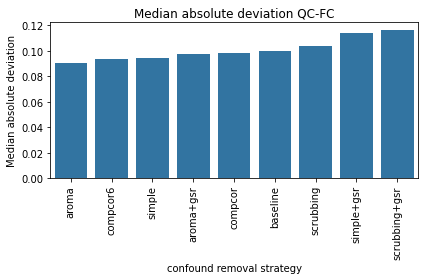

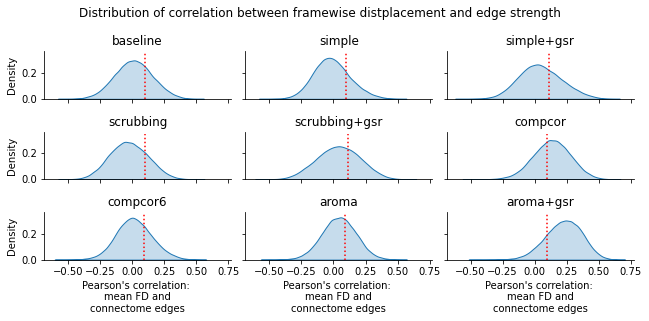

In [13]:
median_absolute = metric_per_edge.apply(calculate_median_absolute)
order = median_absolute.sort_values().index.tolist()

ax = sns.barplot(data=(pd.DataFrame(median_absolute).T), ci=None, order=order, color=bar_color)
ax.set_title("Median absolute deviation QC-FC")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(ylabel="Median absolute deviation",
       xlabel="confound removal strategy")
plt.tight_layout()
plt.savefig("mad_qcfc.png", dpi=300)

def draw_absolute_median(data, **kws):
    ax = plt.gca()
    mad = calculate_median_absolute(data['qcfc'])
    ax.vlines(mad, ymin=0, ymax=0.35, color='r', linestyle=':')
    

long_qcfc = metric_per_edge.melt()
long_qcfc.columns = ["Strategy", "qcfc"]
long_qcfc["row"] = np.sort(np.tile(np.arange(3), int(long_qcfc.shape[0] / 3)))
long_qcfc["col"] = np.tile(np.sort(np.tile(np.arange(3), int(long_qcfc.shape[0] / 9))), 3)

g = sns.displot(
    long_qcfc, x="qcfc", col="col", row="row", kind='kde', fill=True, height=1.5, aspect=2
)
g.set(ylabel="Density")
g.map_dataframe(draw_absolute_median)
for i, name in zip(range(9), metric_per_edge.columns):
    axis_i = int(i / 3)
    axis_j = i % 3
    g.facet_axis(axis_i, axis_j).set(title=name)
    if axis_i == 2:
        g.facet_axis(axis_i, axis_j).set(xlabel="Pearson\'s correlation: \nmean FD and\nconnectome edges")
        
g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle('Distribution of correlation between framewise distplacement and edge strength')
plt.tight_layout()
plt.savefig("dist_qcfc.png", dpi=300)

#### Distance dependence of motion
Distance dependence of motion has been reduced for all strategies.

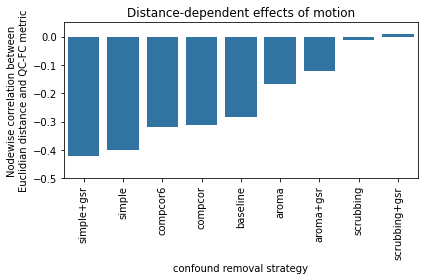

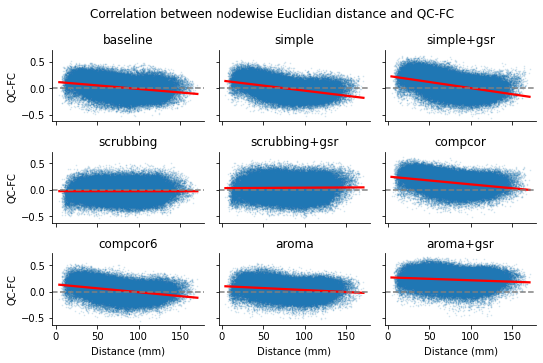

In [12]:
corr_distance, p_val = spearmanr(pairwise_distance.iloc[:, -1], metric_per_edge)  

corr_distance = pd.DataFrame(corr_distance[1:, 0], index=metric_per_edge.columns)
long_qcfc['distance'] = np.tile(pairwise_distance.iloc[:, -1].values, 9)

order = corr_distance.sort_values(0).index.tolist()

ax = sns.barplot(data=corr_distance.T, ci=None, order=order, color=bar_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Distance-dependent effects of motion")
ax.set(ylim=(-0.5, 0.05))
ax.set(ylabel="Nodewise correlation between\nEuclidian distance and QC-FC metric",
        xlabel="confound removal strategy")
plt.tight_layout()
plt.savefig("corr_dist_qcfc_mean.png", dpi=300)

g = sns.FacetGrid(long_qcfc, col="col", row="row", height=1.7, aspect=1.5)
g.map(sns.regplot, 'distance', 'qcfc', fit_reg=True, ci=None, 
      line_kws={'color': 'red'}, scatter_kws={'s': 0.5, 'alpha': 0.15,})
g.refline(y=0)
for i, name in zip(range(9), metric_per_edge.columns):
    axis_i = int(i / 3)
    axis_j = i % 3
    g.facet_axis(axis_i, axis_j).set(title=name)
    if axis_i == 2:
        g.facet_axis(axis_i, axis_j).set(xlabel="Distance (mm)")
    if axis_j == 0:
        g.facet_axis(axis_i, axis_j).set(ylabel="QC-FC")
        
g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle('Correlation between nodewise Euclidian distance and QC-FC')
plt.tight_layout()
plt.savefig("corr_dist_qcfc_dist.png", dpi=300)

All strategies other than `aroma` improved the network modularity comparing to the raw signal.
The network modularity between `aroma` and the raw signal are similar. 
To confirm whether network identifiability was systematically impacted by motion, we also evaluated the correlation between modularity quality and motion for each denoising approach. Compcor based strategy and ICA-AROMA strategy are the best at eliminating the correlation between motion and modularity.

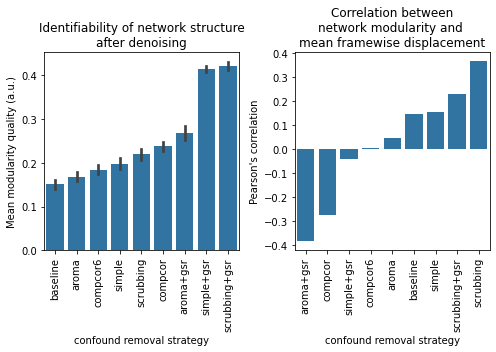

In [15]:
corr_modularity = []
z_movement = movement.apply(zscore)
for column, values in modularity.iteritems():
    current_strategy = partial_correlation(values.values, 
                                           movement['mean_framewise_displacement'].values, 
                                           z_movement[['Age', 'Gender']].values)
    current_strategy['strategy'] = column
    corr_modularity.append(current_strategy)

plt.figure(figsize=(7, 5))
plt.subplot(1, 2, 1)
order = modularity.mean().sort_values().index.tolist()
ax = sns.barplot(data=modularity, order=order, color=bar_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Identifiability of network structure\nafter denoising")
ax.set(ylabel="Mean modularity quality (a.u.)",
       xlabel="confound removal strategy")
plt.subplot(1, 2, 2)

corr_modularity = pd.DataFrame(corr_modularity).sort_values('correlation')
ax = sns.barplot(data=corr_modularity, y='correlation', x='strategy', ci=None, color=bar_color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Correlation between\nnetwork modularity and \nmean framewise displacement")
ax.set(ylabel="Pearson's correlation",
       xlabel="confound removal strategy")
plt.tight_layout()
plt.savefig("modularity.png", dpi=300)

### Conclusions

We could replicate findings regarding the usefulness of standard strategies (compcorr, aroma etc.), the denoising methods involving global signal regression are systematically contradicting with the literature {cite:p}`ciric_benchmarking_2017` {cite:p}`parkes_evaluation_2018`. 
Further investigation is needed.
We will run the same benchmark on different fMRIPrepLTS outputs and different types of parcellation schemes.
The aim is to provide a software for researchers to produce the benchmark for their own dataset to select the most suitable strategy.

### References
```{bibliography}
:filter: docname in docnames
```